In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.backend import mean, square

from spektral.datasets import qm9
from spektral.layers import EdgeConditionedConv, GlobalAttentionPool
from spektral.utils import label_to_one_hot

Using TensorFlow backend.


In [2]:
%load_ext tensorboard
!rm -rf ./logs/
import datetime

In [3]:
A, X, E, y = qm9.load_data(return_type='numpy',
                           nf_keys='atomic_num',
                           ef_keys='type',
                           self_loops=True,
                           amount=4000)  # Set to None to train on whole dataset
# one-hot labeling of atoms
uniq_X = np.unique(X)
X = label_to_one_hot(X, uniq_X)

Loading QM9 dataset.
Reading SDF


100%|██████████| 4000/4000 [00:01<00:00, 2301.44it/s]


In [4]:
y

,mol_id,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,gdb_3996,3.33117,1.516440,1.358690,1.0785,68.31,-0.2459,0.0010,0.2469,986.2809,0.139181,-400.944193,-400.935445,-400.934501,-400.977158,31.893,-1565.545221,-1575.164307,-1584.647850,-1452.224626
3996,gdb_3997,3.21675,1.545420,1.343710,0.9421,68.25,-0.2486,0.0004,0.2490,983.7517,0.139515,-400.947904,-400.939105,-400.938161,-400.981336,32.281,-1567.873907,-1577.460990,-1586.944533,-1454.846359
3997,gdb_3998,3.70487,1.351230,0.996100,0.6382,70.97,-0.2459,-0.0376,0.2084,1091.3741,0.091451,-361.346440,-361.337818,-361.336874,-361.379798,30.819,-1327.810927,-1333.955495,-1341.067054,-1241.734889
3998,gdb_3999,3.70937,1.364910,1.003890,4.0964,65.92,-0.2614,-0.0540,0.2074,1060.7387,0.081305,-377.453740,-377.445525,-377.444580,-377.486899,28.613,-1246.538471,-1252.049255,-1258.567191,-1166.714934


In [5]:
# tasks = ['alpha', 'cv', 'g298_atom', 'gap', 'h298_atom', 'lumo', 'r2', 'u0_atom', 'u298_atom', 'zpve']
tasks = ['zpve', 'h298_atom']
# tasks = list(y.columns)[1:]
num_tasks = len(tasks)
y_list = []
for task in tasks:
    y_list.append(y[[task]].values)

# Transforms the output values to have mean 0 and variance 1
# To legitimately use this network as a prediction tool, we will need to save 
# the fit parameters and transform back at the end
for i in range(len(y_list)):
    y_list[i] = StandardScaler().fit_transform(y_list[i]).reshape(-1, y_list[-1].shape[-1])

In [6]:
# y_list = []
# for col in list(y.columns)[1:]:
#     y_list.append(y[[col]].values)

# for i in range(len(y_list)):
#     y_list[i] = StandardScaler().fit_transform(y_list[i]).reshape(-1, y_list[-1].shape[-1])

In [7]:
N = X.shape[-2]           # Number of nodes in the graphs
F = X.shape[-1]           # Node features dimensionality
S = E.shape[-1]           # Edge features dimensionality
n_out = y_list[0].shape[-1]    # Dimensionality of the target
learning_rate = 1e-3      # Learning rate for SGD
epochs = 3               # Number of training epochs # formerly 25
batch_size = 64           # Batch size
es_patience = 5           # Patience fot early stopping
soft = False
soft_weight = 0.1

In [8]:
# tasks = ['zpve']
# num_tasks = len(tasks)
# keys = list(y.columns)[1:]
# values = [i for i in range(len(y.columns)-1)]
# task_to_index = dict(zip(keys, values))

In [9]:
A_train, A_test, \
X_train, X_test, \
E_train, E_test, \
*y_train_test_list = train_test_split(A, X, E, *y_list, test_size = 0.1)

y_train_list = y_train_test_list[::2]
y_test_list = y_train_test_list[1::2]

In [10]:
# y_train_list = np.array(y_train_list)
# other_y_train_list = np.r_[y_train_list[1:2, :, :], y_train_list[3:4, :, :]]
# print(other_y_train_list.shape)

In [11]:
X_in = Input(shape=(N, F))
A_in = Input(shape=(N, N))
E_in = Input(shape=(N, N, S))

In [12]:
def create_single_task_model(X_in, A_in, E_in):
    gc1 = EdgeConditionedConv(64, activation='relu')([X_in, A_in, E_in])
    gc2 = EdgeConditionedConv(128, activation='relu')([gc1, A_in, E_in])
    pool = GlobalAttentionPool(256)(gc2)
    dense = Dense(256, activation='relu')(pool)
    output = Dense(n_out)(dense)
    return Model(inputs=[X_in, A_in, E_in], outputs=output)

In [13]:
def create_hard_paramter_sharing_model(X_in, A_in, E_in):
    gc1 = EdgeConditionedConv(64, activation='relu')([X_in, A_in, E_in])
    gc2 = EdgeConditionedConv(128, activation='relu')([gc1, A_in, E_in])
    pool = GlobalAttentionPool(256)(gc2)
    dense_list = [Dense(256, activation='relu')(pool) for i in range(num_tasks)]
    output_list = [Dense(n_out)(dense_layer) for dense_layer in dense_list]
    return Model(inputs=[X_in, A_in, E_in], outputs=output_list)

In [14]:
def create_soft_paramter_sharing_model_and_loss(X_in, A_in, E_in, soft_weight):
    gc1_list = [EdgeConditionedConv(64, activation='relu')([X_in, A_in, E_in]) for i in range(num_tasks)]
    gc2_list = [EdgeConditionedConv(128, activation='relu')([gc1_layer, A_in, E_in]) for gc1_layer in gc1_list]
    pool_list = [GlobalAttentionPool(256)(gc2_layer) for gc2_layer in gc2_list]
    dense_list = [Dense(256, activation='relu')(pool_layer) for pool_layer in pool_list]
    output_list = [Dense(n_out)(dense_layer) for dense_layer in dense_list]
    model = Model(inputs=[X_in, A_in, E_in], outputs=output_list)
    
    def loss(y_true, y_pred):
        avg_layer_diff = 0
        for i in range(len(dense_list)):
            for j in range(i):
                avg_layer_diff += mean(square(dense_list[i]-dense_list[j]))
        avg_layer_diff /= len(dense_list)
        return mean(square(y_pred - y_true)) + soft_weight*avg_layer_diff
    
    return Model(inputs=[X_in, A_in, E_in], outputs=output_list), loss

In [15]:
optimizer = Adam(lr=learning_rate)
if soft:
    model, loss = create_soft_paramter_sharing_model_and_loss(X_in, A_in, E_in, soft_weight)
    model.compile(optimizer=optimizer, loss=loss)
else:
    model = create_hard_paramter_sharing_model(X_in, A_in, E_in)
    model.compile(optimizer=optimizer, loss='mse')
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 5)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 9, 9)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 9, 9, 1)      0                                            
__________________________________________________________________________________________________
edge_conditioned_conv_1 (EdgeCo (None, 9, 64)        704         input_1[0][0]                    
                                                                 input_2[0][0]                    
        

In [16]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
es_callback = EarlyStopping(monitor='val_loss', patience=es_patience)

In [18]:
model.fit([X_train, A_train, E_train],
          y_train_list,
          batch_size=batch_size,
          validation_split=0.1,
          epochs=epochs,
          callbacks=[es_callback, tensorboard_callback])



Train on 3240 samples, validate on 360 samples



Epoch 1/3
3240/3240 [==============================] - 120s 37ms/step - loss: 1.2412 - dense_3_loss: 0.5932 - dense_4_loss: 0.6480 - val_loss: 0.8673 - val_dense_3_loss: 0.3995 - val_dense_4_loss: 0.4678
Epoch 2/3
3240/3240 [==============================] - 111s 34ms/step - loss: 0.6476 - dense_3_loss: 0.3044 - dense_4_loss: 0.3432 - val_loss: 0.4773 - val_dense_3_loss: 0.2546 - val_dense_4_loss: 0.2227
Epoch 3/3
3240/3240 [==============================] - 111s 34ms/step - loss: 0.3749 - dense_3_loss: 0.2030 - dense_4_loss: 0.1719 - val_loss: 0.3401 - val_dense_3_loss: 0.1914 - val_dense_4_loss: 0.1487


In [19]:
print('Evaluating model.')
eval_results = model.evaluate([X_test, A_test, E_test],
                              y_test_list,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}'.format(eval_results))

Evaluating model.
400/400 [==============================] - 1s 1ms/step
Done.
Test loss: [0.31544499516487123, 0.17520070254802703, 0.14024429261684418]


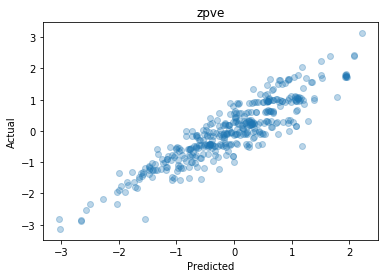

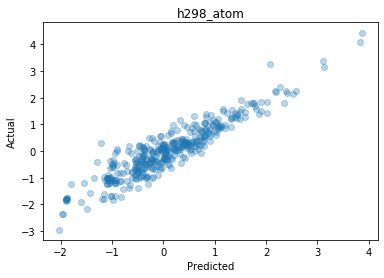

In [20]:
preds = model.predict([X_test, A_test, E_test])

if num_tasks == 1:
    preds = np.transpose(preds)

for i in range(num_tasks):
    plt.figure()
    plt.scatter(preds[i], y_test_list[i], alpha=0.3)
    plt.plot()
    plt.title(tasks[i])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # plt.savefig('graphs/' + '11_5_'+tasks[i]+'_multitask')

In [21]:
%tensorboard --logdir logs/fit